In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
(train, _), (test, _) = cifar10.load_data()

# scaling input data
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

train_noise = add_noise_and_clip_data(train)
test_noise = add_noise_and_clip_data(test)

170500096/170498071 [==============================] - 98s 1us/step


In [3]:
def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

In [4]:
def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)
    
    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)
    
    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [5]:
model = autoencoder()

def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True, save_weights_only = True)

model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     18496       batch_normalization[0][0]        
________________________________________________________________________________________

In [6]:
# Training
history = model.fit(train_noise,
                    train,
                    validation_data = (test_noise, test),
                    epochs = 10,
                    batch_size = 128,
                    shuffle = True, 
                    callbacks = [checkpoint, callbacks, lr])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.5310
Epoch 00001: val_loss improved from inf to 0.10816, saving model to best_model.h5
391/391 [==============================] - 1514s 4s/step - loss: 0.6302 - accuracy: 0.5310 - val_loss: 0.1082 - val_accuracy: 0.6188 - lr: 1.0000e-04
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.6893
Epoch 00002: val_loss improved from 0.10816 to 0.02119, saving model to best_model.h5
391/391 [==============================] - 1531s 4s/step - loss: 0.0421 - accuracy: 0.6893 - val_loss: 0.0212 - val_accuracy: 0.7135 - lr: 1.0000e-04
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.7423
Epoch 00003: val_loss improved from 0.02119 to 0.01067, saving model to best_model.h5
391/391 [==============================] - 1477s 4s/step - loss: 0.0123 - accuracy: 0.7423 - val_loss: 0.0107 - val_accuracy: 0.7554 - lr: 1.0000e-04
Epoch 4/

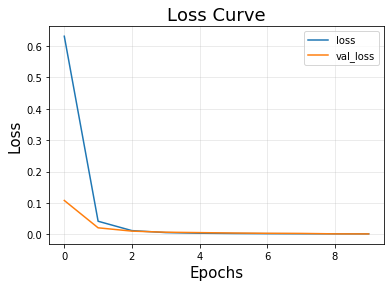

In [7]:
#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [8]:
denoised = model.predict(train_noise)

In [9]:
def show_denoised(idx):
  plt.subplot(1,3,1)
  plt.imshow(train[idx])
  plt.title('Original image')
  plt.subplot(1,3,2)
  plt.imshow(train_noise[idx])
  plt.title('Image with noise')
  plt.subplot(1,3,3)
  plt.imshow(denoised[idx])
  plt.title('Denoised Image')
  plt.show()


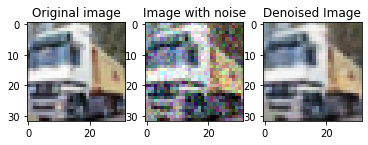

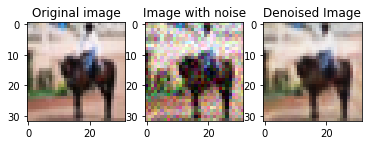

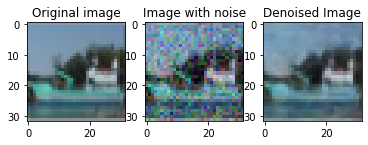

In [10]:
show_denoised(1)
show_denoised(11)
show_denoised(111)

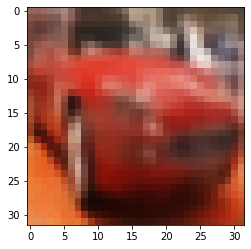

In [11]:
idx=5
plt.imshow(model.predict(train[idx-1:idx+1])[1]) 